In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import os
import numpy as np
from copy import deepcopy
import py3Dmol
from ipywidgets import interact, IntSlider
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)

import plotly as pl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import seaborn as sns
sns.set(style="whitegrid")

import ast
import math
import random as random
import copy
np.random.seed(7678)
from sklearn.metrics import auc, roc_curve

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

pl.offline.init_notebook_mode(connected=True)


from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
import sys
sys.path.insert(0, '../MutCat/')
#import ccal # Original repository is in https://github.com/UCSD-CCAL/ccal
#from ancillary_v1_0 import *

In [3]:
CCLE_pathways = pd.read_table('/home/ebc/variome/CT2/ccal_PT/Inference/data/CCLE_19Q3/CCLE_expression.PATHWAYS.c2_c5_h.gct',sep='\t', skiprows=2,index_col=0).drop('Description',1)

sig = CCLE_pathways.loc['SINGH_NFE2L2_TARGETS',:].sort_values(ascending = False)
sig_mean = sig.mean()
sig_std = sig.std()

sig_Act = pd.Series(np.where(sig >= sig_mean + sig_std, 1, 0), 
                     index = sig.index, name='Active_sample')

sig_Null = pd.Series(np.where(sig < sig_mean - sig_std, 1, 0), 
                     index = sig.index, name='Unactive_sample')

del CCLE_pathways

In [4]:
DF_CCLE = pd.read_csv('/media/ebc/F47A-25A8/PDBMap_Backup/CCLE/XYZ/GW_Full_Gene_XYZ.csv',index_col=0)

In [5]:
DF_prob_map = pd.read_csv('~/variome/GIT/MutCat/analysis/NRF2/dataframes/GW/DF_Prob_cluster_size_gt_2_MAP_TO_TUMORBARCODE.csv',index_col=0)
DF_Prob_All_dist = pd.read_csv('~/variome/GIT/MutCat/analysis/NRF2/dataframes/GW/DF_Prob_cluster_size_gt_2_MAP_TO_CLUSTERING.csv',index_col=0)

In [6]:
ROC_thres = 0.5
sig_thres = sig.mean()+sig.std()
ii = 0

In [7]:
df_sig = pd.DataFrame(sig)
df_sig = df_sig.reset_index()
df_sig.rename(columns={'index':'Tumor_Sample_Barcode'},inplace=True)


sig_thres_act = sig.mean()+sig.std()
sig_thres_unact = sig.mean()-sig.std()

In [8]:
# only predict variants where we have signature data for
for_test_train = DF_prob_map[DF_prob_map.Tumor_Sample_Barcode.isin(sig_Act.index)][['Hugo_Symbol','Tumor_Sample_Barcode','var_id']].drop_duplicates()

print("Num Genes: %s, Num variants: %s"%(len(for_test_train.Hugo_Symbol.unique()),len(for_test_train.var_id.unique())))

Num Genes: 4877, Num variants: 93464


In [9]:
test_train_split = 0.8

# get test/train data
msk = np.random.rand(len(df_sig)) < test_train_split
train = df_sig[msk]
test = df_sig[~msk]

print(len(train),len(test))

923 287


In [10]:
# separate pre-computed probabilities for train/test sets

train = for_test_train[for_test_train.Tumor_Sample_Barcode.isin(train.Tumor_Sample_Barcode)]
test = for_test_train[for_test_train.Tumor_Sample_Barcode.isin(test.Tumor_Sample_Barcode)]

test = test.sort_values('Tumor_Sample_Barcode',ascending=True)
train = train.sort_values('Tumor_Sample_Barcode',ascending=True)

print("Num Genes in train: %s, Num variants in train: %s"%(len(train.Hugo_Symbol.unique()),len(train.var_id.unique())))
print("Num tumor samples in train: %s"%(len(train.Tumor_Sample_Barcode.unique())))
print()
      
print("Num Genes in test: %s, Num variants in test: %s"%(len(test.Hugo_Symbol.unique()),len(test.var_id.unique())))
print("Num tumor samples in test: %s"%(len(test.Tumor_Sample_Barcode.unique())))

Num Genes in train: 4876, Num variants in train: 77302
Num tumor samples in train: 850

Num Genes in test: 4405, Num variants in test: 18229
Num tumor samples in test: 259


In [11]:
def get_cond_probability_from_subset(c,sig_Act):

    N = len(sig_Act)-1

    prob_c = pd.Series(c['act'].value_counts()/N, name = 'prob_c')
    prob_Act = pd.Series(sig_Act.value_counts()/N, name = 'prob_Act')
    joint_counts_Act_vs_c = pd.crosstab(sig_Act, c['act'])
    joint_prob_Act_vs_c = joint_counts_Act_vs_c/N
    cond_prob_Act_given_c = joint_prob_Act_vs_c.div(prob_c, axis='columns')


    cond_prob_sum = np.mean(cond_prob_Act_given_c.sum(axis=0).values)

    try:
        cond_prob_1_1 = np.round(cond_prob_Act_given_c, decimals=3).values[1][1]
        cond_prob_1_0 = np.round(cond_prob_Act_given_c, decimals=3).values[1][0]
        cond_prob_0_0 = np.round(cond_prob_Act_given_c, decimals=3).values[0][0]
        cond_prob_0_1 = np.round(cond_prob_Act_given_c, decimals=3).values[0][1]
        
    except IndexError:
        pass

    return(cond_prob_1_1)

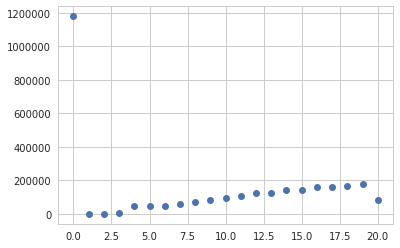

In [13]:
to_plot = pd.Series(np.round(DF_prob_map[(DF_prob_map.dist<20)].dist.values,decimals=0)).value_counts()

to_plot = to_plot.sort_index()

#to_plot = to_plot[to_plot>100]

plt.plot(to_plot.index.tolist(),to_plot.values,'o')

No handles with labels found to put in legend.


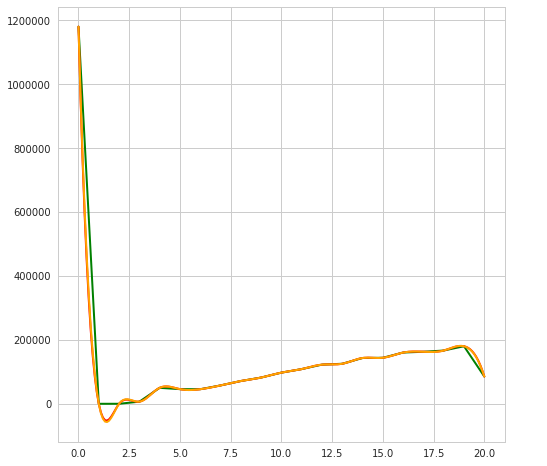

In [14]:
#from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate

from scipy import ndimage

y= to_plot.values
x = to_plot.index.tolist()

# convert both to arrays
x_sm = np.array(x)
y_sm = np.array(y)

# resample to lots more points - needed for the smoothed curves
x_smooth = np.linspace(x_sm.min(), x_sm.max(), 200)

# spline - always goes through all the data points x/y
y_spline = interpolate.spline(x, y, x_smooth)

spl = interpolate.UnivariateSpline(x, y)

sigma = 2
x_g1d = ndimage.gaussian_filter1d(x_sm, sigma)
y_g1d = ndimage.gaussian_filter1d(y_sm, sigma)

fig, ax = plt.subplots(figsize=(8, 8))
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

plt.plot(x_sm, y_sm, 'green', linewidth=2)
plt.plot(x_smooth, y_spline, 'red', linewidth=2)
plt.plot(x_smooth, spl(x_smooth), 'orange', linewidth=2)
#plt.plot(x_g1d,y_g1d, 'magenta', linewidth=1)

plt.show()

In [15]:
import numpy as np
from scipy.signal import argrelextrema

x = y_spline

# for local maxima
ind_max = argrelextrema(y_spline, np.greater)

# for local minima
ind_min = argrelextrema(y_spline, np.less)

local_max = x_smooth[ind_max]
print("maxima: ",local_max)

local_min = x_smooth[ind_min]
print("minima: ",local_min)

maxima:  [ 2.4120603   4.32160804 12.26130653 14.27135678 16.58291457 18.89447236]
minima:  [ 1.40703518  2.91457286  5.42713568 12.56281407 14.77386935 17.38693467]


In [16]:
def get_naive_bayes_probability(c,sig_Act):

    N = len(sig_Act)-1

    prob_c = pd.Series(c['act'].value_counts()/N, name = 'prob_c')
    prob_Act = pd.Series(sig_Act.value_counts()/N, name = 'prob_Act')
    joint_counts_Act_vs_c = pd.crosstab(sig_Act, c['act'])
    joint_prob_Act_vs_c = joint_counts_Act_vs_c/N
    cond_prob_Act_given_c = joint_prob_Act_vs_c.div(prob_c, axis='columns')

    cond_prob_sum = np.mean(cond_prob_Act_given_c.sum(axis=0).values)

    try:
        cond_prob_1_1 = np.round(cond_prob_Act_given_c, decimals=3).values[1][1]
        #cond_prob_1_0 = np.round(cond_prob_Act_given_c, decimals=3).values[1][0]
        #cond_prob_0_0 = np.round(cond_prob_Act_given_c, decimals=3).values[0][0]
        cond_prob_0_1 = np.round(cond_prob_Act_given_c, decimals=3).values[0][1]
        
    except IndexError:
        cond_prob_1_1 = np.nan
        cond_prob_0_1 = np.nan
        LOR = np.nan
        
    if pd.notnull(cond_prob_1_1) & pd.notnull(cond_prob_0_1):
        nom = np.true_divide(cond_prob_1_1,cond_prob_0_1)
        denom = np.true_divide(prob_Act.values[1],prob_Act[0])
        
        LOR = np.log(np.true_divide(nom,denom))
        

    return(LOR)